In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
import pandas as pd
plt.rcParams["figure.figsize"] = [8, 6]

# Spreading Factor

## Airtime

The higher the SF parameter is, the longer it takes to send a packet.
As the duty cycle limitation is computed based on the airtime, the higher SF were chosen less often than the lower.

In [11]:
def insert_packet(spreading_factor):
    if spreading_factor < 7:
        return []
    return insert_packet(spreading_factor - 1) + [spreading_factor] + insert_packet(spreading_factor - 1)

sf_as_category = pd.Categorical(insert_packet(12), categories=[7, 8, 9, 10, 11, 12], ordered=True)
pyramid = pd.DataFrame({'SF': sf_as_category})
pyramid['seq_num'] = pyramid.index

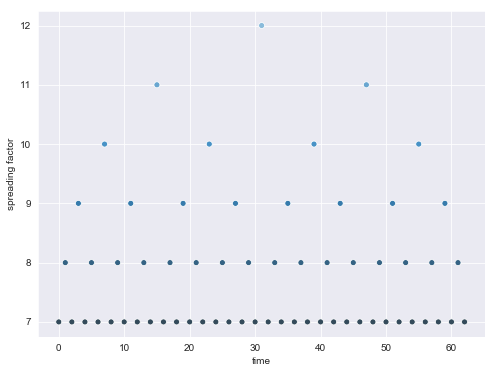

In [20]:
cmap = sns.color_palette('Blues_d', 6)
fig = sns.scatterplot(x=pyramid.index, y='SF', data=pyramid, hue='SF', legend=False, palette=cmap)
fig.set_ylabel('spreading factor')
fig.set_xlabel('time')
fig.figure.savefig('../sf_sequence.png')

In [17]:
pyramid.groupby('SF').count().T

SF,7,8,9,10,11,12
seq_num,32,16,8,4,2,1


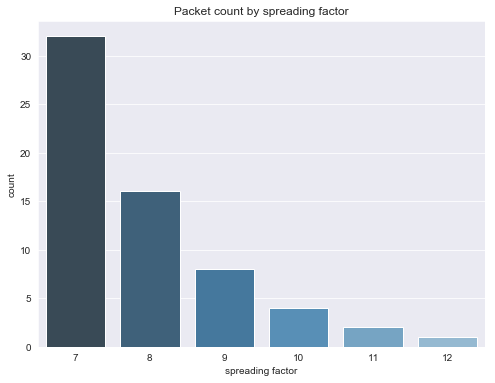

In [18]:
fig = sns.countplot('SF', data=pyramid, palette=cmap)
fig.set_xlabel('spreading factor')
fig.set_title('Packet count by spreading factor');

Using airtime calculator: https://avbentem.github.io/lorawan-airtime-ui/ttn/eu868/5

In [7]:
lorawan_airtime = pd.DataFrame({'SF': [7, 8, 9, 10, 11, 12],
                                'airtime': [51.46, 92.67, 185.34, 329.73, 659.46, 1318.91]})
lorawan_airtime['airtime'] = lorawan_airtime['airtime'] / 1000
packet_sequence = pyramid.merge(lorawan_airtime, on='SF', how='inner').sort_values('seq_num').set_index('seq_num')

In seconds, the airtime per 24 hours is equal to

In [8]:
index = pd.timedelta_range(start='0 day', periods=len(packet_sequence.index) * 100, freq='10 min')
tenminute_sequence = packet_sequence
for i in range(99):
    tenminute_sequence = tenminute_sequence.append(packet_sequence)
tenminute_sequence.index = index
tenminute_sequence.resample('1D').sum()['airtime'][0:-1].mean()

19.582314883720912

which is below the [fair access policy of TheThingsNetwork (30 seconds / 24h)](https://forum.thethingsnetwork.org/t/limitations-data-rate-packet-size-30-seconds-day-fair-access-policy-nodes-per-gateway/1300).

To the contrary, sending a packet every 5 minute would exceed TheThingsNetwork fair access policy. 

## Daily packet count


In [9]:
daily_count_by_sf = tenminute_sequence[['SF']].groupby('SF').resample('1D').count()[:-1].rename(columns={'SF': 'count'})
daily_count_by_sf.mean(level=0).T



SF,7,8,9,10,11,12
count,72.727273,36.363636,18.181818,9.090909,4.545455,2.302326
